# Learning a pseudo-Hamiltonian PDE with a pseudo-Hamiltonian neural network

## Introduction

In this notebook, we will use a Pseudo-Hamiltonian neural network to learn a partial differential equation (PDE) from a data set that represents solutions $u : \mathbb{R}^d \times \mathbb{R} \to \mathbb{R}^d$ of the PDE. We assume that the PDE is first-order in time and $p$-order in space, so that it can be written as
$
\begin{equation}
    u_t = g(u,u_x,u_{xx},\ldots,u_{px}, x, t),
    \tag{1}
\end{equation}
$
for $u \in H^p(\Omega), x \in \Omega \subseteq \mathbb{R}^d, t \in \mathbb{R}$.

Letting $u^\alpha := (u,u_x,u_{xx},\ldots,u_{px})$, we propose to use a pseudo-Hamiltonian formulation
$
\begin{equation}
    A(u^\alpha, x) u_t = S(u^\alpha, x) \frac{\delta \mathcal{H}}{\delta u}[u] - R(u^\alpha, x) \frac{\delta \mathcal{V}}{\delta u}[u] + f(u^\alpha, x, t),
    \tag{2}
\end{equation}
$
where $A(u^\alpha, x)$, $S(u^\alpha, x)$ and $R(u^\alpha, x)$ are operators that are respectively symmetric, skew-symmetric and positive semi-definite with respect to the $L^2$ inner product, $\mathcal{H}$ and $\mathcal{V}$ are integrals of the form
$
\begin{equation}
    \mathcal{H}[u] = \int_\Omega H(x, u, u_x) dx,
    \tag{3}
\end{equation}
$
$\frac{\delta \mathcal{H}}{\delta u}$ denotes the variational (or *functional*) derivative of $\mathcal{H}$, and $f: \mathbb{R}^{p+1} \times \mathbb{R}^d \times \mathbb{R} \to \mathbb{R}$. Note that any PDE like Eq. (1) can be written on the form of Eq. (2), with
$
\begin{equation}
    g(u^\alpha, x) = A(u^\alpha, x)^{-1} \left( S(u^\alpha, x) \frac{\delta \mathcal{H}}{\delta u}[u] - R(u^\alpha, x) \frac{\delta \mathcal{V}}{\delta u}[u] + f(u^\alpha, x, t) \right).
    \tag{4}
\end{equation}
$

We exploit the structure of Eq. $(2)$ to learn any Hamiltonian or dissipative integrals separately, so that we can integrate the learned system in a structure-preserving way.

For more details about the pseudo-Hamiltonian framework, see ["Pseudo-Hamiltonian neural networks for learning partial differential equations"](https://doi.org/10.1016/j.jcp.2023.112738).

## Task

The equation covered in this notebook is the Korteweg–de Vries equation, without external forces. The equation is given by
$
\begin{equation}
    u_t + \eta u u_x + \gamma^2 u_{xx} = 0,
    \tag{5}
\end{equation}
$
with initial condition $u(x,0) = u_0(x)$ and periodic boundary conditions $u(P,t) = u(0,t)$.
This equation can be written in the form of Eq. (2) with
$
\begin{equation}
    \mathcal{H}[u] = -\int_\Omega \left( \frac{\eta}{6} u^3 - \frac{\gamma^2}{2} u_x^2 \right) \ dx \qquad \text{and} \qquad S = \frac{\partial}{\partial x},
    \tag{6}
\end{equation}
$
and $A = 1$, $R = 0$ and $f=0$.

You are free to change the variables below in capital letters as you like.

In [1]:
import torch

ttype = torch.float32
torch.set_default_dtype(ttype)

#### Generate training data

We use the `phlearn` package in order to generate the training data, which are numerical solutions to the exact PDE. The training data consists of `NUM_TRAJECTORIES` different initial conditions, evaluated at the timesteps specified up until the final time.

In [ ]:
import numpy as np

# Recommended wave-specific parameters
ETA = 6.0
GAMMA = 1.0
NUM_SOLITONS = 2  # 1, 2, 3, ...

# Parameters for the spatial dimension
NUM_SPATIAL_POINTS = 100
PERIOD = 20

# Temporal parameters
TIMESTEP = 0.01
MAX_TIME = 0.05
NUM_TRAJECTORIES = 5  # Number of initial conditions to use

x = np.linspace(0, PERIOD - PERIOD / NUM_SPATIAL_POINTS, NUM_SPATIAL_POINTS)
t_axis = np.arange(0, MAX_TIME, TIMESTEP)

In [3]:
from kdv_utils import generate_KdV_data

KdV_system, traindata, t_axis = generate_KdV_data(
    x,
    t_axis,
    ETA,
    GAMMA,
    NUM_SOLITONS,
    NUM_TRAJECTORIES,
)

100%|████████████████████████████████████| 5/5 [00:00<00:00, 38.34it/s]


#### Set up the pseudo-Hamiltonian neural network

We set the kernel sizes of the discrete convolution operators representing discretizations of the operators $A$, $S$ and $R$.

The kernel sizes determine what kind of a system the model is able to learn. For instance, the default here, $[1, 3, 0, 0]$, specifies that $A=1$, $S=\frac{\partial}{\partial x}$, $R=0$ and $f=0$. Thus no learning is needed for these operators. This specification means that the model can only learn conservative systems, and no dissipation or external forces. In this case, learning the conserved integral $\mathcal{H}$ means learning the full system dynamics.

This set-up is chosen here since it is enough to describe the KdV equation. The kernel sizes can be specified on a problem-to-problem basis, and you can increase the integers in `KERNEL_SIZES` below to set up a more general model.

In [4]:
import phlearn.phnns as phnn

KERNEL_SIZES = [1, 3, 0, 0]
phmodel = phnn.PseudoHamiltonianPDENN(NUM_SPATIAL_POINTS, KERNEL_SIZES)

#### Train the model

We train the model $\hat{g}_\theta$ with the loss function
$
\begin{equation}
    \mathcal{L}_{\hat{g}_\theta} =
    \left\lVert
        \frac{u^{j+1} - u^j}{\Delta t}
        - \hat{g}_\theta \left(
            \frac{(u^\alpha)^j + (u^\alpha)^{j+1}}{2}, x, \frac{t^j + t^{j+1}}{2}
        \right)
    \right\rVert_2^2,
    \tag{5}
\end{equation}
$
given here for one training point $u$, utilizing the implicit midpoint method. The gradients are optimized using the Adam optimizer. The function `phnn.train` implements this method, returning the model which performed best during training.

In [ ]:
NUM_EPOCHS = 5000
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = torch.optim.Adam(
    phmodel.parameters(), LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

phmodel, _ = phnn.train(
    phmodel,
    integrator="midpoint",
    traindata=traindata,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
)

  0%|                                         | 0/5000 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/phnn_pde/lib/python3.10/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|█████| 5000/5000 [01:07<00:00, 73.74it/s, epoch=4999, loss=0.0183]


#### Generate and plot the results

We compare the learned model against the true PDE by integrating from an initial condition not used in training, on a longer time scale than was present in the training data. The training data consists of data up to $t = 0.05$ by default, with the generated predictions being up to $t = 2$.

In [6]:
FINAL_TEST_TIME = 2.0
TEMPORAL_RESOLUTION = 200

t_test = np.linspace(0, FINAL_TEST_TIME, TEMPORAL_RESOLUTION)

u_exact, *_ = KdV_system.sample_trajectory(t_test)
u_phnn, _ = phmodel.simulate_trajectory(
    integrator=False, t_sample=t_test, x0=u_exact[0], xspatial=x
)

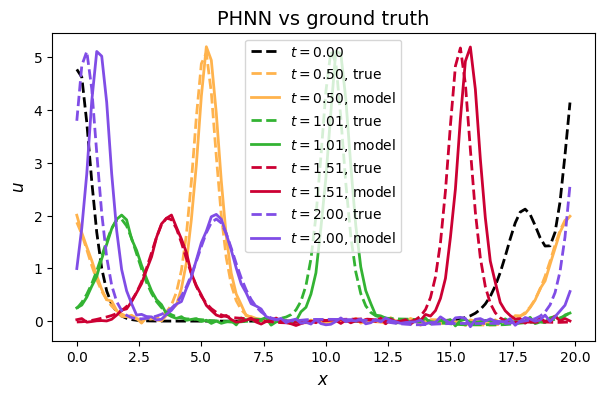

In [7]:
from kdv_utils import plot_solutions

plot_solutions(u_exact, u_phnn, x, t_test)

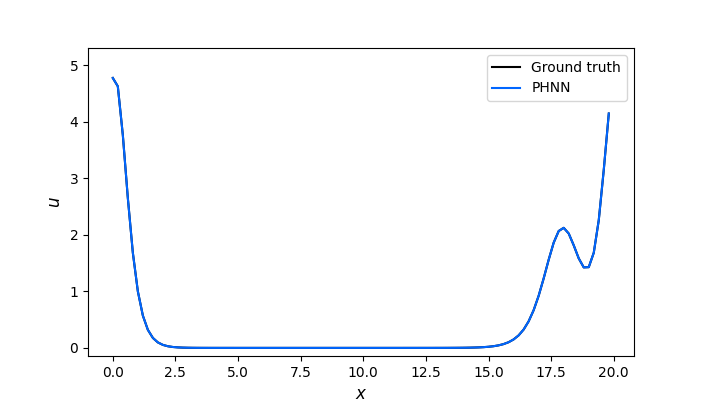

In [8]:
from phlearn.utils import create_video

MAKE_VIDEOS = True

if MAKE_VIDEOS:
    create_video(
        [u_exact, u_phnn],
        ["Ground truth", "PHNN"],
        x_axis=x,
        file_name="pure_kdv.gif",
        output_format="GIF",
    )